In [1]:
pip install pandas numpy scipy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade networkx

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
import statsmodels.api as sm
import networkx as nx

from networkx.algorithms.community import greedy_modularity_communities


from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import MDS
from sklearn.decomposition import TruncatedSVD
import community as community_louvain
import matplotlib.cm as cm
from networkx.algorithms.community import girvan_newman

#  Step 1-Load and Prepare Data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the dataset and handle missing data
df = pd.read_csv('DataForTable2.1 (1).csv')

# Impute missing data with the mean for each column
df.fillna(df.mean(), inplace=True)

# Convert 'year' to integer if it's not already
df['year'] = df['year'].astype(int)

# Preview the data
print("Data preview:")
print(df.head())

Data preview:
  Country name  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008        3.724               7.350           0.451   
1  Afghanistan  2009        4.402               7.509           0.552   
2  Afghanistan  2010        4.758               7.614           0.539   
3  Afghanistan  2011        3.832               7.581           0.521   
4  Afghanistan  2012        3.783               7.661           0.521   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                              50.5                         0.718       0.164   
1                              50.8                         0.679       0.187   
2                              51.1                         0.600       0.118   
3                              51.4                         0.496       0.160   
4                              51.7                         0.531       0.234   

   Perceptions of corruption  Positive affect  Negative affe

/var/folders/z5/36fz2y8j5dqdzn04zypyxy8h0000gn/T/ipykernel_78636/783400269.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


# Step 2 - Visualizing Data

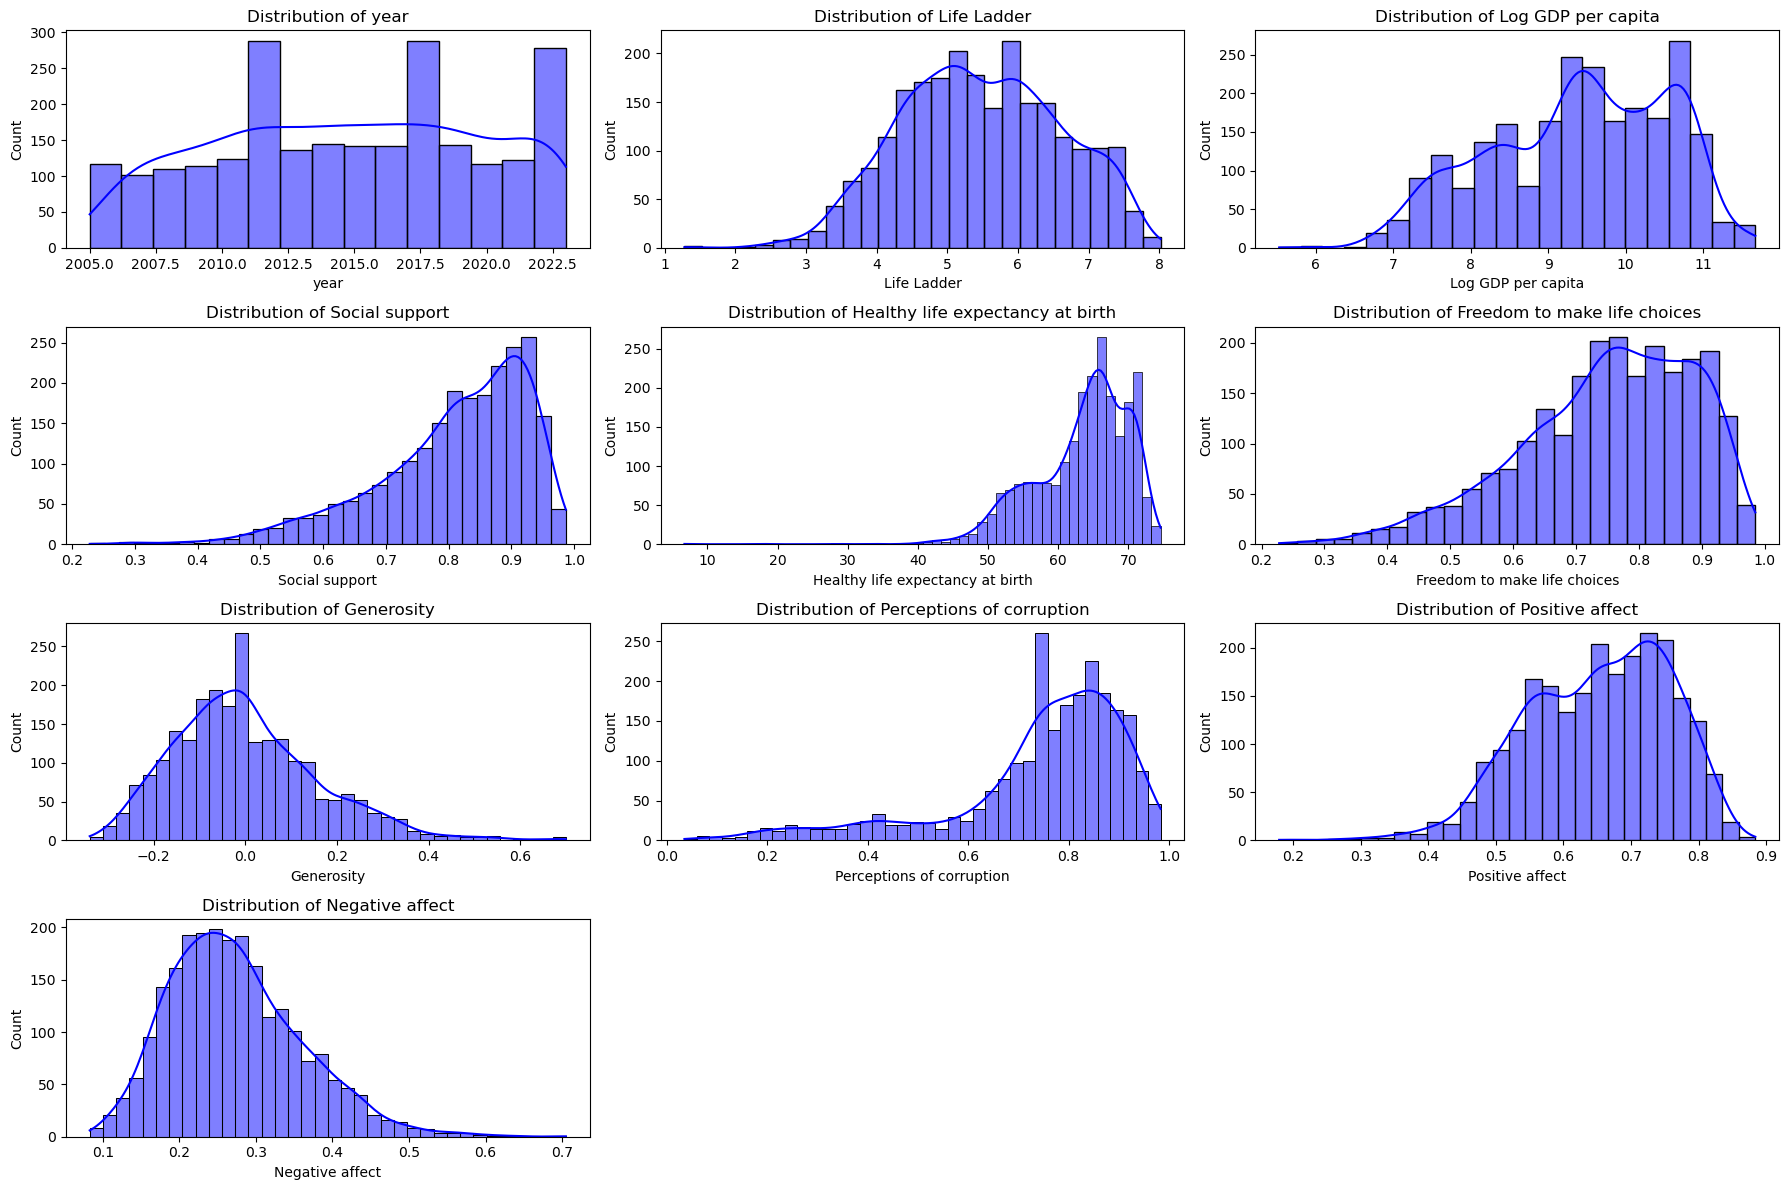

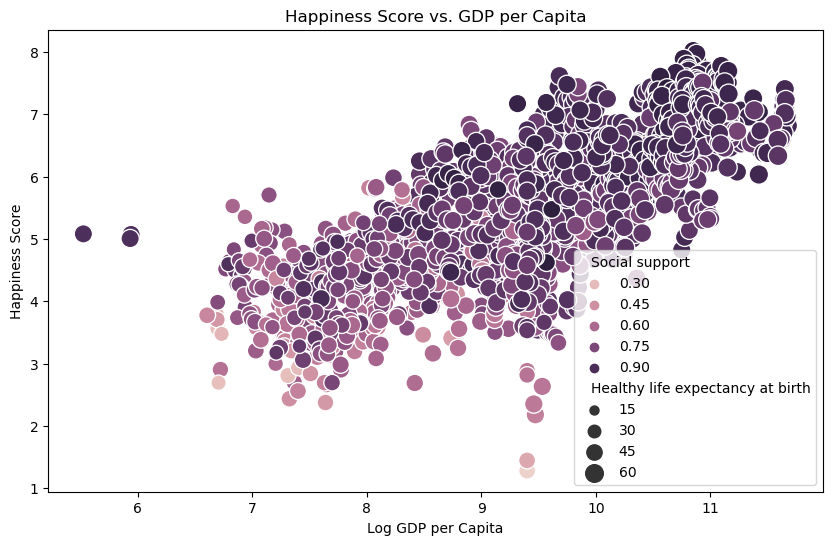

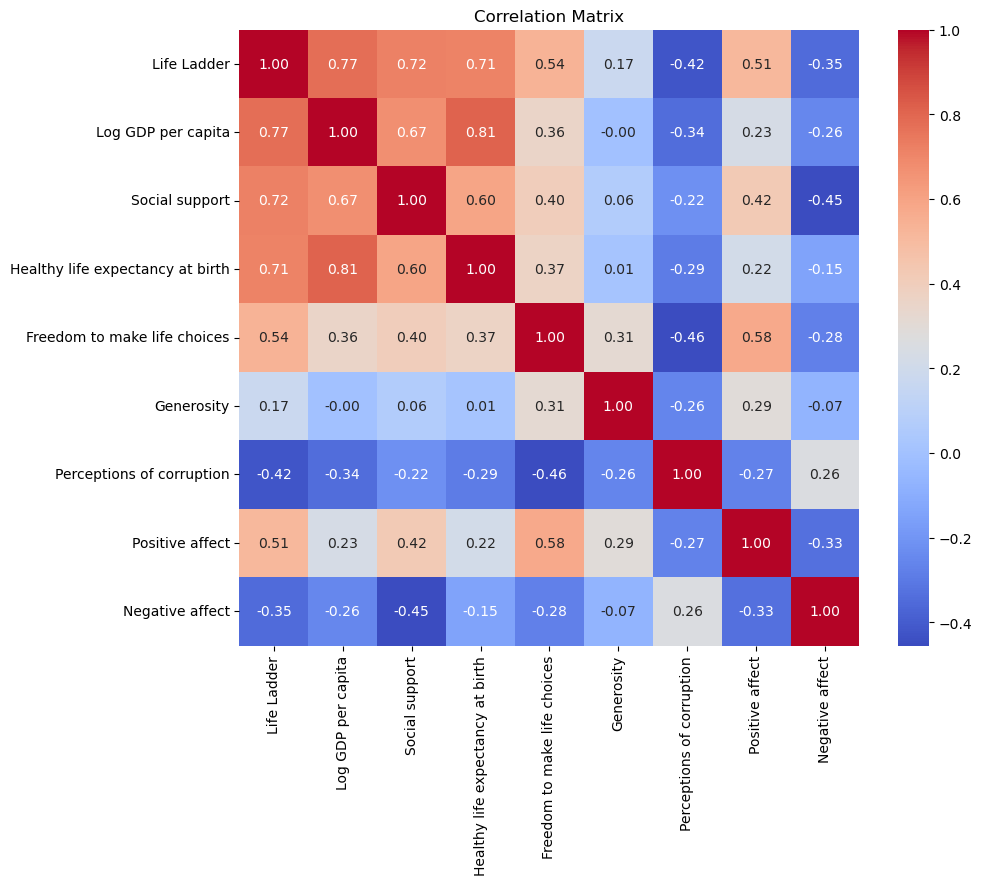

/var/folders/z5/36fz2y8j5dqdzn04zypyxy8h0000gn/T/ipykernel_78636/1637163970.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='year', y='Life Ladder', estimator='mean', ci=None)


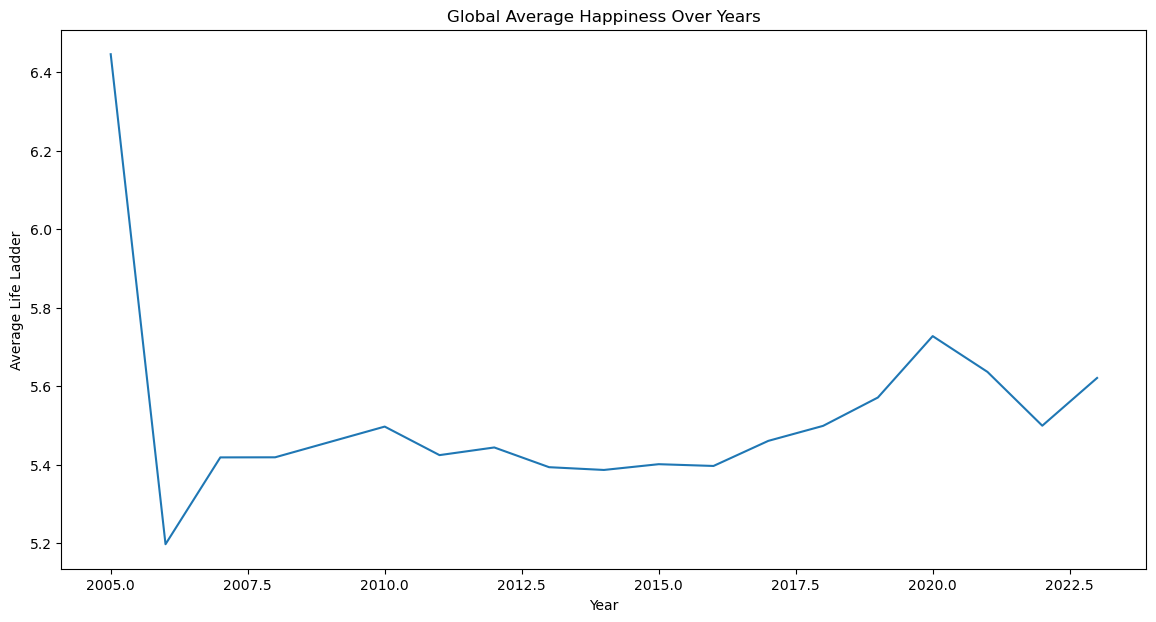

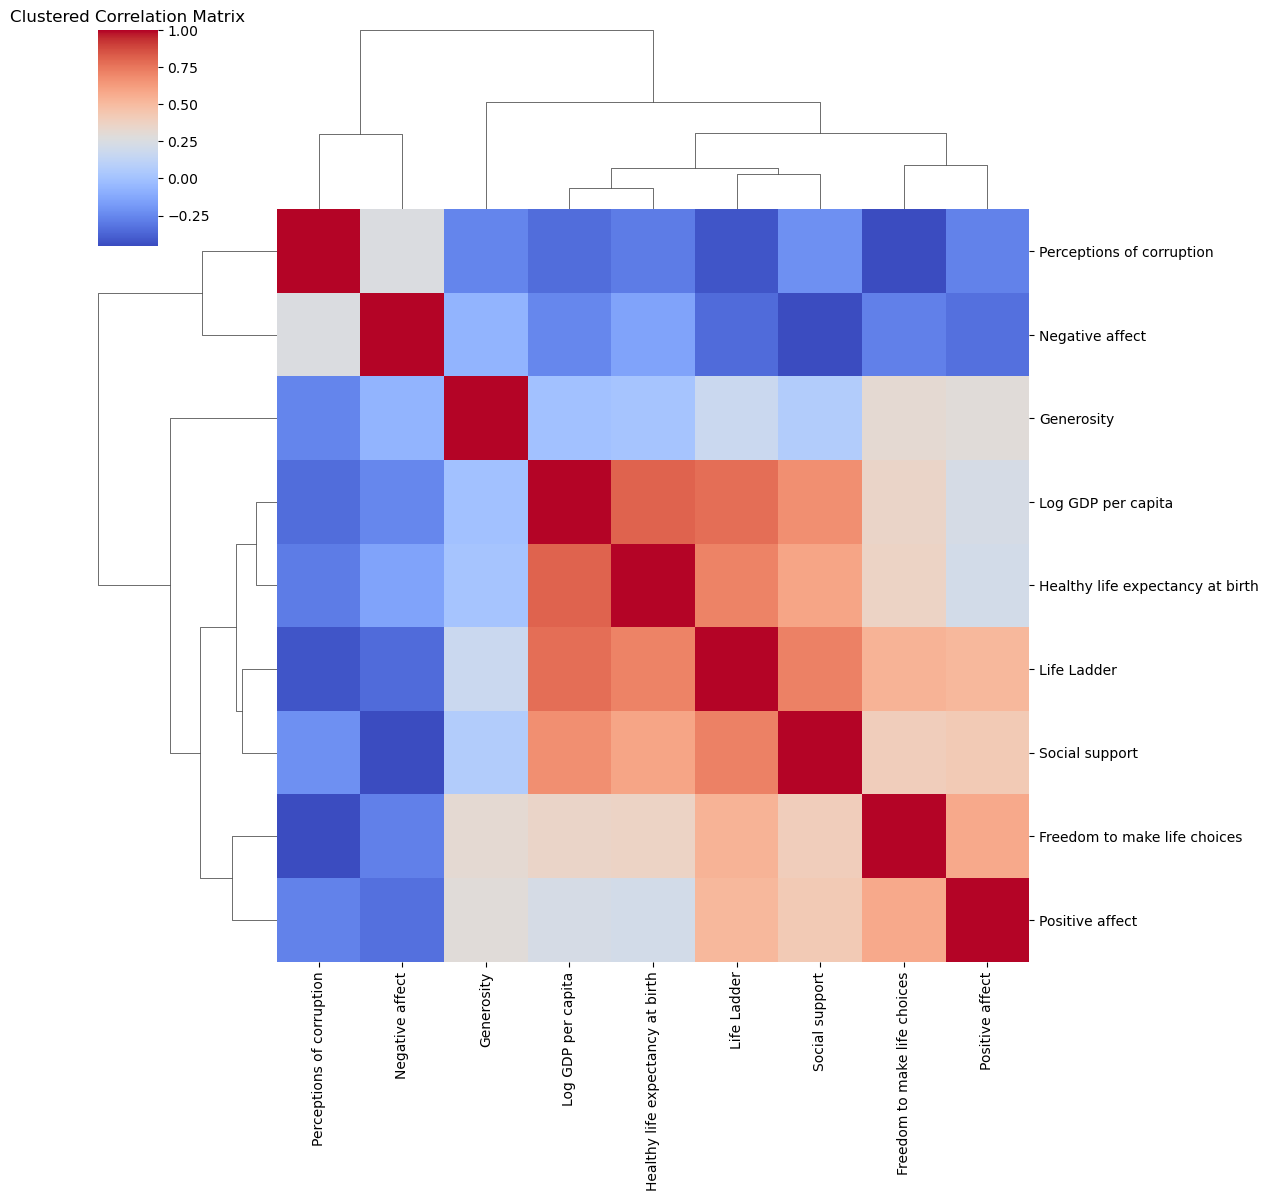

In [6]:
# Initial Visualization with Histograms for each numerical attribute
plt.figure(figsize=(18, 12))
for i, column in enumerate(df.select_dtypes(include=np.number).columns, 1):
    plt.subplot(4, 3, i)  # Adjusted to accommodate all numeric columns
    sns.histplot(df[column], kde=True, color='blue')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# Scatter plot of GDP vs. Happiness
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Log GDP per capita', y='Life Ladder', hue='Social support', size='Healthy life expectancy at birth', sizes=(20, 200), data=df)
plt.title('Happiness Score vs. GDP per Capita')
plt.xlabel('Log GDP per Capita')
plt.ylabel('Happiness Score')
plt.show()

# Heatmap of correlations
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Time Series Plot for 'Life Ladder' across years globally
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='year', y='Life Ladder', estimator='mean', ci=None)
plt.title('Global Average Happiness Over Years')
plt.xlabel('Year')
plt.ylabel('Average Life Ladder')
plt.show()

# Cluster Map to visualize groupings within the data based on correlation
sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(12, 12))
plt.title('Clustered Correlation Matrix')
plt.show()




# Step 3 - Transforming Data

In [7]:


# Step 3: Transforming Data
numeric_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
scaler = StandardScaler()
features = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 
            'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 
            'Positive affect', 'Negative affect']
df[features] = scaler.fit_transform(df[features])
df['Economic Impact Index'] = df['Log GDP per capita'] * df['Healthy life expectancy at birth']

# PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df[features])
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
outliers = principalDf[np.abs(principalDf['PC1']) > 5]  # Outliers threshold set at 5 standard deviations
outlier_countries = df.loc[outliers.index, 'Country name']

# Factor Analysis
factor = FactorAnalysis(n_components=2)
factorComponents = factor.fit_transform(df[features])
factorDf = pd.DataFrame(data=factorComponents, columns=['Factor1', 'Factor2'])
dominant_factors = factorDf.idxmax(axis=1)

# Cross-Product Matrix
cross_product_matrix = np.dot(df[features].T, df[features])

# Minimums Method Matrix
# Using minimum values to identify the weakest links between features
min_values = np.min(df[features].values, axis=0)
min_matrix = np.outer(min_values, min_values)

# Identify the threshold for weak links (e.g., lower quartile)
threshold = np.quantile(min_matrix, 0.25)

# Print weak links that are below the threshold
print("Weak Links in Minimum Matrix:")
for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features):
        if min_matrix[i, j] < threshold:
            print(f"Weak link between {feature_i} and {feature_j} with value {min_matrix[i, j]:.2f}")


# Bipartite Matrix Conversion
countries = df['Country name'].unique()
years = df['year'].unique()
bipartite_matrix = pd.DataFrame(0, index=countries, columns=years)
for index, row in df.iterrows():
    bipartite_matrix.loc[row['Country name'], row['year']] = 1

# Print the results
print("Data Head with PCA Components:\n", df.head())
print("\nOutlier Countries based on PCA:\n", outlier_countries)
print("\nDominant Factors in Factor Analysis:\n", dominant_factors.value_counts())
print("\nCross Product Matrix:\n", cross_product_matrix)
# print("\nWeakest Links in Minimum Matrix:\n", min_matrix)
print("\nBipartite Matrix:\n", bipartite_matrix)


Weak Links in Minimum Matrix:
Weak link between Log GDP per capita and Generosity with value 7.25
Weak link between Log GDP per capita and Negative affect with value 7.41
Weak link between Freedom to make life choices and Generosity with value 8.10
Weak link between Freedom to make life choices and Negative affect with value 8.27
Weak link between Generosity and Log GDP per capita with value 7.25
Weak link between Generosity and Freedom to make life choices with value 8.10
Weak link between Generosity and Generosity with value 4.60
Weak link between Generosity and Perceptions of corruption with value 8.45
Weak link between Generosity and Negative affect with value 4.70
Weak link between Perceptions of corruption and Generosity with value 8.45
Weak link between Perceptions of corruption and Negative affect with value 8.63
Weak link between Negative affect and Log GDP per capita with value 7.41
Weak link between Negative affect and Freedom to make life choices with value 8.27
Weak link b

# Step 4 - Quantitative Analysis

Regression Analysis Summary:
                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1497.
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        19:27:35   Log-Likelihood:                -1942.9
No. Observations:                2363   AIC:                             3898.
Df Residuals:                    2357   BIC:                             3932.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4836  

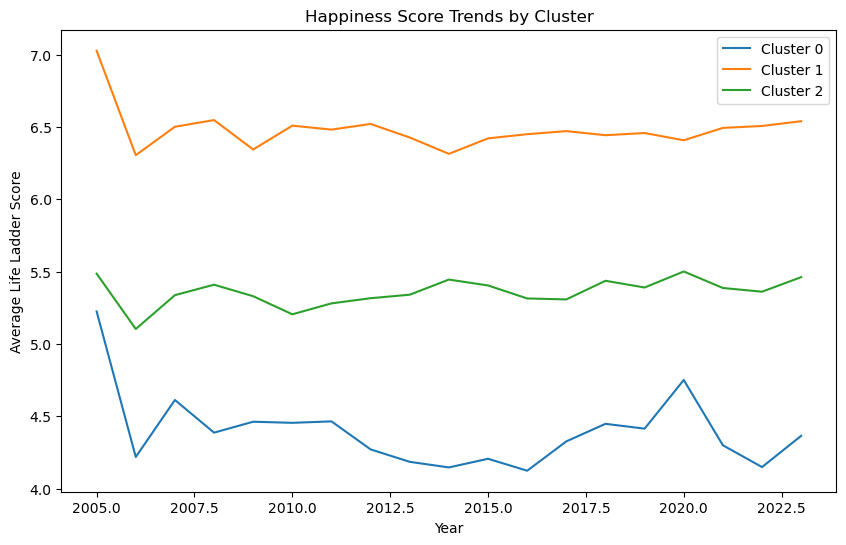

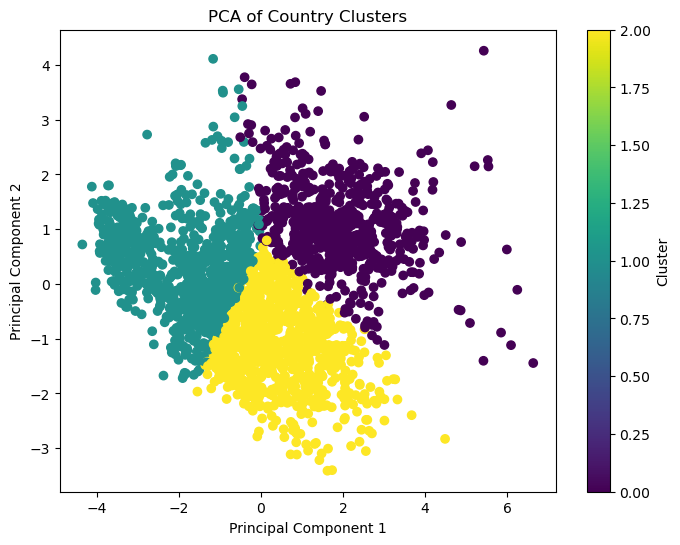

Countries in each cluster:
Cluster 0: ['Afghanistan' 'Angola' 'Bangladesh' 'Benin' 'Bolivia' 'Botswana'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Central African Republic'
 'Chad' 'Comoros' 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Djibouti'
 'Eswatini' 'Ethiopia' 'Gabon' 'Gambia' 'Ghana' 'Guatemala' 'Guinea'
 'Guyana' 'Haiti' 'Honduras' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ivory Coast' 'Kenya' 'Kosovo' 'Laos' 'Lesotho' 'Liberia' 'Madagascar'
 'Malawi' 'Mali' 'Mauritania' 'Morocco' 'Mozambique' 'Myanmar' 'Namibia'
 'Nepal' 'Niger' 'Nigeria' 'Pakistan' 'Philippines' 'Rwanda' 'Senegal'
 'Sierra Leone' 'Somalia' 'South Africa' 'South Sudan'
 'State of Palestine' 'Sudan' 'Syria' 'Tajikistan' 'Tanzania' 'Togo'
 'Uganda' 'Venezuela' 'Yemen' 'Zambia' 'Zimbabwe']
Cluster 1: ['Argentina' 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Belgium'
 'Belize' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Canada'
 'Chile' 'China' 'Colombia' 'Costa Rica' 'Cyprus' 'Czechia' 'Denmark'
 'Domin

In [8]:


import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Using principal components for further analysis
# Prepare data for regression using Principal Components
X = principalDf  # Using all principal components
y = df['Life Ladder']
X = sm.add_constant(X)  # Adding a constant for the intercept

# Fit OLS regression model using principal components
model = sm.OLS(y, X).fit()
print("Regression Analysis Summary:")
print(model.summary())

# Cluster Analysis using K-Means on Principal Components
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['Cluster'] = kmeans.labels_

# Time-Series Analysis by Cluster
plt.figure(figsize=(10, 6))
for name, group in df.groupby('Cluster'):
    grouped = group.groupby('year')['Life Ladder'].mean()
    plt.plot(grouped.index, grouped, label=f'Cluster {name}')
plt.title('Happiness Score Trends by Cluster')
plt.xlabel('Year')
plt.ylabel('Average Life Ladder Score')
plt.legend()
plt.show()

# PCA for Visualization using 2 components for easy plotting
pca = PCA(n_components=2)
principalComponents_2D = pca.fit_transform(X.iloc[:, 1:])  # Exclude the constant added for regression
principalDf_2D = pd.DataFrame(data=principalComponents_2D, columns=['PC1', 'PC2'])

# Plotting the clusters based on 2D PCA
plt.figure(figsize=(8, 6))
plt.scatter(principalDf_2D['PC1'], principalDf_2D['PC2'], c=df['Cluster'], cmap='viridis', label=df['Cluster'].astype(str))
plt.title('PCA of Country Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Identify countries in each cluster
clusters_countries = df.groupby('Cluster')['Country name'].unique()
print("Countries in each cluster:")
for cluster, countries in clusters_countries.items():
    print(f"Cluster {cluster}: {countries}")








Top 5 Countries by Degree Centrality:
Moldova 0.6585365853658537
Sri Lanka 0.6585365853658537
Vietnam 0.6585365853658537
Brazil 0.6463414634146342
Egypt 0.6280487804878049
Number of communities: 3
Community 1: ['Armenia', 'Sweden', 'Bahrain', 'Belgium', 'United Arab Emirates', 'Lithuania', 'Bosnia and Herzegovina', 'Poland', 'Australia', 'China', 'Uruguay', 'Iran', 'Taiwan Province of China', 'Cyprus', 'Estonia', 'Panama', 'Suriname', 'Dominican Republic', 'Argentina', 'Hungary', 'Jamaica', 'Lebanon', 'Somaliland region', 'Sri Lanka', 'Georgia', 'Kazakhstan', 'Latvia', 'Jordan', 'United States', 'Malaysia', 'Russia', 'Peru', 'Italy', 'Croatia', 'Belarus', 'Mexico', 'Moldova', 'Singapore', 'Belize', 'Ukraine', 'Bulgaria', 'Austria', 'Trinidad and Tobago', 'Montenegro', 'Ecuador', 'Iceland', 'Qatar', 'El Salvador', 'Israel', 'Maldives', 'Netherlands', 'Paraguay', 'Chile', 'Tunisia', 'Cuba', 'Costa Rica', 'State of Palestine', 'Albania', 'Colombia', 'Malta', 'Kuwait', 'Slovenia', 'Brazil'

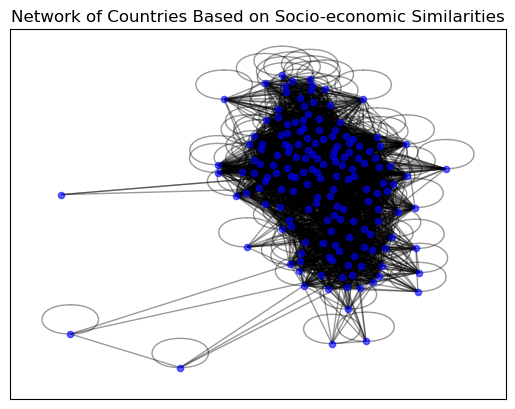

In [9]:
# Build the network
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['Country name'], attr=row[features].to_dict())

# Add edges based on Euclidean distances in feature space
threshold = 2  # distance threshold for connecting nodes
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        distance = np.linalg.norm(df.loc[i, features] - df.loc[j, features])
        if distance < threshold:
            G.add_edge(df.loc[i, 'Country name'], df.loc[j, 'Country name'], weight=(threshold - distance))

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print the top 5 nodes by degree centrality
print('Top 5 Countries by Degree Centrality:')
for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]:
    print(node, degree_centrality[node])

# Community detection
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
print(f'Number of communities: {len(communities)}')
for i, community in enumerate(communities):
    print(f'Community {i + 1}: {list(community)}')

# Visualizing the network
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.title('Network of Countries Based on Socio-economic Similarities')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of communities: 3
Community 1: ['Armenia', 'Sweden', 'Bahrain', 'Belgium', 'United Arab Emirates', 'Lithuania', 'Bosnia and Herzegovina', 'Poland', 'Australia', 'China', 'Uruguay', 'Iran', 'Taiwan Province of China', 'Cyprus', 'Estonia', 'Panama', 'Suriname', 'Dominican Republic', 'Argentina', 'Hungary', 'Jamaica', 'Lebanon', 'Somaliland region', 'Sri Lanka', 'Georgia', 'Kazakhstan', 'Latvia', 'Jordan', 'United States', 'Malaysia', 'Russia', 'Peru', 'Italy', 'Croatia', 'Belarus', 'Mexico', 'Moldova', 'Singapore', 'Belize', 'Ukraine', 'Bulgaria', 'Austria', 'Trinidad and Tobago', 'Montenegro', 'Ecuador', 'Iceland', 'Qatar', 'El Salvador', 'Israel', 'Maldives', 'Netherlands', 'Paraguay', 'Chile', 'Tunisia', 'Cuba', 'Costa Rica', 'State of Palestine', 'Albania', 'Colombia', 'Malta', 'Kuwait', 'Slovenia', 'Brazil', 'Serbia', 'Romania', 'France', 'Turkmenistan', 'Germany', 'Azerbaijan', 'Saudi Arabia', 'South Korea', 'Türkiye', 'Libya', 'North Macedonia', 'Oman', 'Iraq', 'Venezuela',

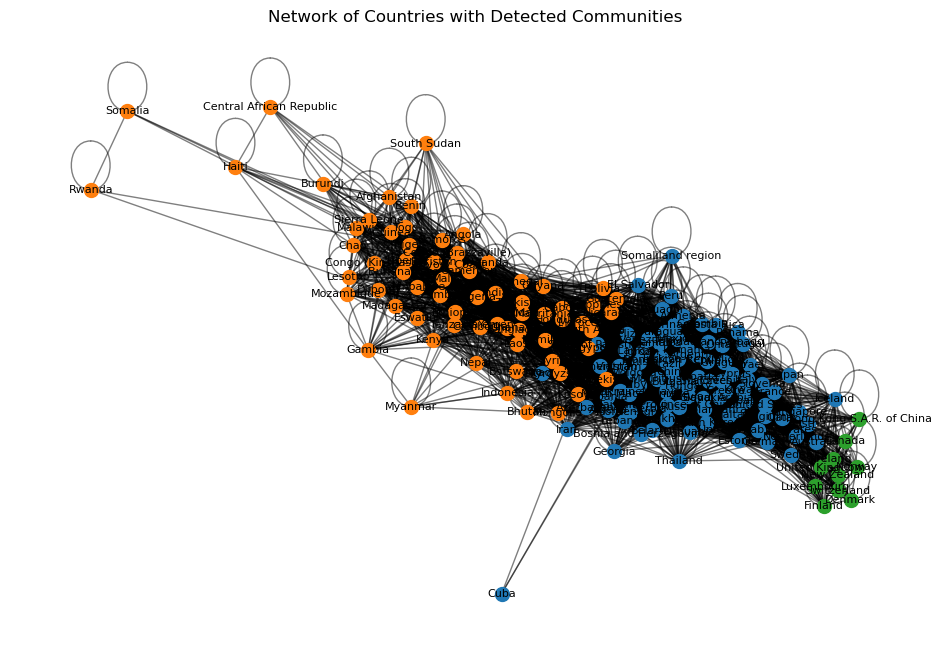

In [10]:


numeric_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
scaler = StandardScaler()
features = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']
df[features] = scaler.fit_transform(df[features])

# Build the network
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['Country name'], attr=row[features].to_dict())

# Add edges based on Euclidean distances in feature space
threshold = 2  # distance threshold for connecting nodes
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        distance = np.linalg.norm(df.loc[i, features] - df.loc[j, features])
        if distance < threshold:
            G.add_edge(df.loc[i, 'Country name'], df.loc[j, 'Country name'], weight=(threshold - distance))

# Community detection
communities = greedy_modularity_communities(G)
print(f'Number of communities: {len(communities)}')
for i, community in enumerate(communities):
    print(f'Community {i + 1}: {list(community)}')

# Visualize the network with communities
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_size=100, node_color=plt.cm.tab10(i))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
plt.title('Network of Countries with Detected Communities')
plt.axis('off')
plt.show()


# Step 5 - Advanced Data Analysis Techniques

Feature importances ranked:
Social support: 0.7725
Healthy life expectancy at birth: 0.0889
Generosity: 0.0500
Freedom to make life choices: 0.0462
Perceptions of corruption: 0.0425
Log GDP per capita: 0.0000


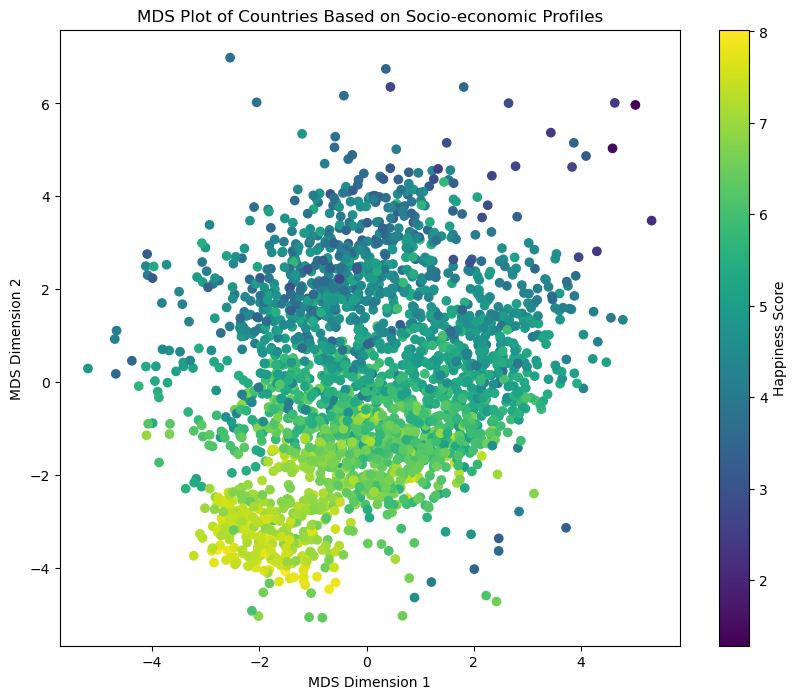

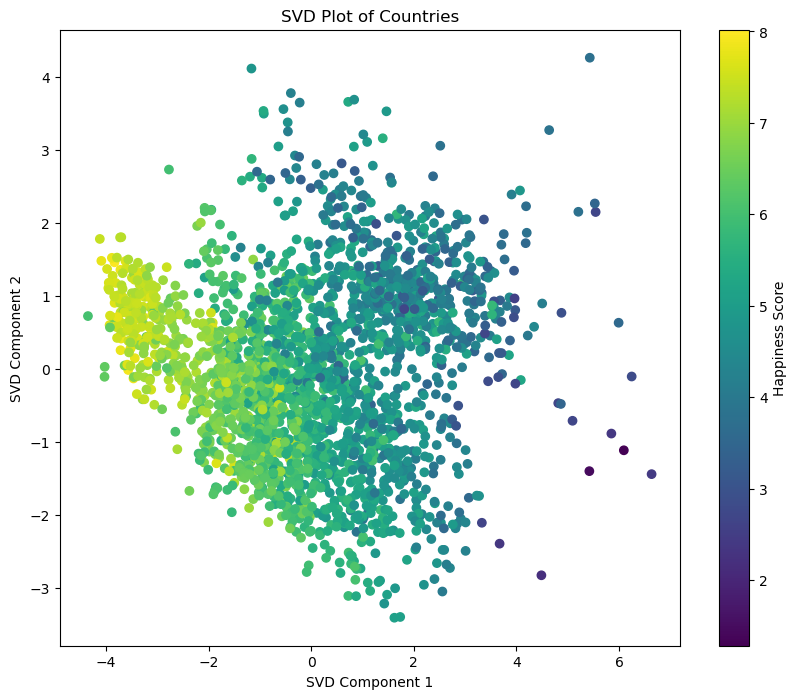

In [11]:

# Machine Learning Model - Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# Feature importance ranking
feature_importance_dict = dict(zip(features, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
print("Feature importances ranked:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Multi-Dimensional Scaling
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='viridis')
plt.colorbar(label='Happiness Score')
plt.title('MDS Plot of Countries Based on Socio-economic Profiles')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

# Singular Value Decomposition
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y, cmap='viridis')
plt.colorbar(label='Happiness Score')
plt.title('SVD Plot of Countries')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()


# Step 6 - Core-Periphery and Factions Analysis

Core countries: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Le

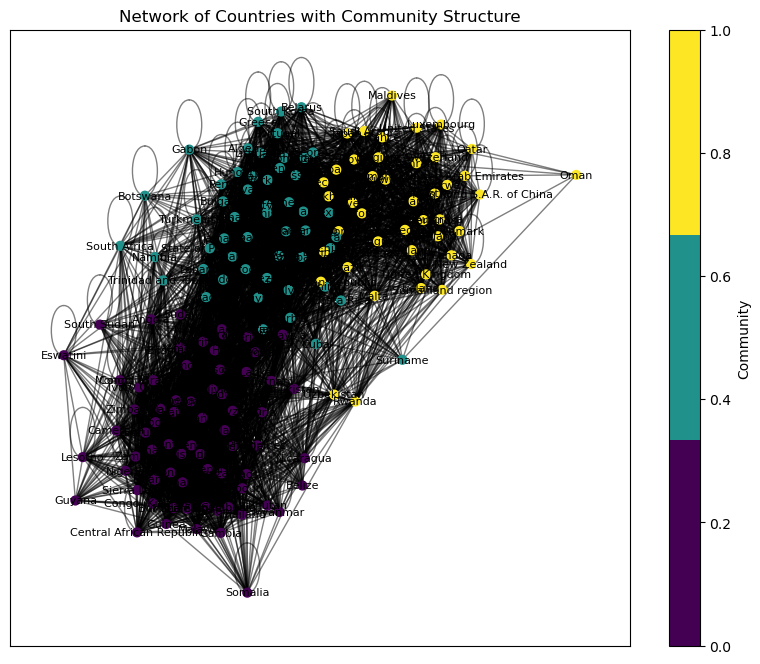

Top central countries based on connectivity:
Serbia: 0.6890
Azerbaijan: 0.6768
Sri Lanka: 0.6402
Ukraine: 0.6402
Malaysia: 0.6280


In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
import community as community_louvain
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler


df.dropna(subset=['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 
                  'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'], inplace=True)
scaler = StandardScaler()
features = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
            'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
df[features] = scaler.fit_transform(df[features].astype(float))

# Build the network graph
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['Country name'], happiness=row['Life Ladder'])

# Add edges based on correlation threshold
threshold = 0.8
for i in range(len(df)):
    for j in range(len(df)):
        if i != j:
            # Convert data to float to ensure it can be handled by np.corrcoef and np.isnan
            data_i = df.iloc[i][features].values.astype(float)
            data_j = df.iloc[j][features].values.astype(float)
            # Check if data contains NaN after conversion and skip if so
            if not np.isnan(data_i).any() and not np.isnan(data_j).any():
                correlation = np.corrcoef(data_i, data_j)[0, 1]
                if correlation > threshold:
                    G.add_edge(df.iloc[i]['Country name'], df.iloc[j]['Country name'], weight=correlation)

# Core-Periphery Model using the girvan_newman algorithm
comp = girvan_newman(G)
core_periphery = tuple(sorted(c) for c in next(comp))
print("Core countries:", core_periphery[0])
print("Periphery countries:", core_periphery[1])

# Factions Analysis using Louvain method for community detection
partition = community_louvain.best_partition(G, resolution=1.0)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # positions for all nodes
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.colorbar(cm.ScalarMappable(cmap=cmap), label='Community')
plt.title('Network of Countries with Community Structure')
plt.show()

# Network Analysis Techniques
# Measures of centrality
centrality = nx.degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("Top central countries based on connectivity:")
for country, cent in sorted_centrality[:5]:  # Top 5 central countries
    print(f"{country}: {cent:.4f}")


# Step 7 - Bipartite Modelling

Is the graph bipartite? True


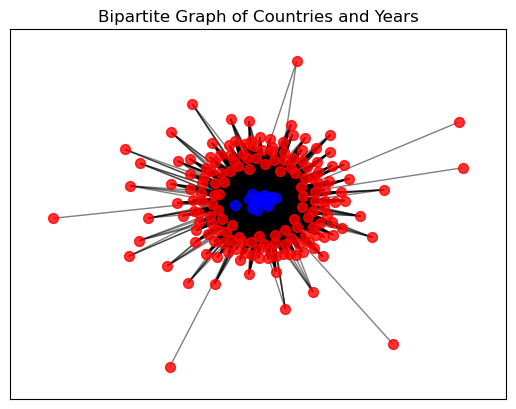

2017.0: 0.8033
2011.0: 0.7978
2014.0: 0.7869
2019.0: 0.7814
2015.0: 0.7760
2012.0: 0.7705
2016.0: 0.7705
2018.0: 0.7705
2022.0: 0.7650
2023.0: 0.7541
2013.0: 0.7432
2010.0: 0.6776
2021.0: 0.6667
2020.0: 0.6339
2009.0: 0.6230
2008.0: 0.6011
2007.0: 0.5574
2006.0: 0.4863
2005.0: 0.1475
Argentina: 0.0984
Bangladesh: 0.0984
Bolivia: 0.0984
Brazil: 0.0984
Cambodia: 0.0984
Cameroon: 0.0984
Canada: 0.0984
Chile: 0.0984
Colombia: 0.0984
Costa Rica: 0.0984
Denmark: 0.0984
Dominican Republic: 0.0984
Ecuador: 0.0984
Egypt: 0.0984
El Salvador: 0.0984
France: 0.0984
Georgia: 0.0984
Germany: 0.0984
Ghana: 0.0984
India: 0.0984
Indonesia: 0.0984
Israel: 0.0984
Italy: 0.0984
Japan: 0.0984
Jordan: 0.0984
Kazakhstan: 0.0984
Kenya: 0.0984
Kyrgyzstan: 0.0984
Lebanon: 0.0984
Lithuania: 0.0984
Mexico: 0.0984
Moldova: 0.0984
Nepal: 0.0984
Nicaragua: 0.0984
Pakistan: 0.0984
Peru: 0.0984
Philippines: 0.0984
Russia: 0.0984
Saudi Arabia: 0.0984
Senegal: 0.0984
South Africa: 0.0984
South Korea: 0.0984
Spain: 0.098

In [13]:
from networkx.algorithms import bipartite
B = nx.Graph()

# Add nodes with the bipartite attribute
# Adding countries as one partition (0)
countries = df['Country name'].unique()
B.add_nodes_from(countries, bipartite=0)

# Adding years as another partition (1)
years = df['year'].unique()
B.add_nodes_from(years, bipartite=1)

# Add edges based on the DataFrame entries
for index, row in df.iterrows():
    B.add_edge(row['Country name'], row['year'])

# Check if the graph is bipartite
print("Is the graph bipartite?", bipartite.is_bipartite(B))

# Visualize the bipartite graph
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B, pos, nodelist=countries, node_color='r', node_size=50, alpha=0.8)
nx.draw_networkx_nodes(B, pos, nodelist=years, node_color='b', node_size=50, alpha=0.8)
nx.draw_networkx_edges(B, pos, alpha=0.5)
plt.title('Bipartite Graph of Countries and Years')
plt.show()

degree_centrality_year = nx.degree_centrality(B)

# Print degree centrality for each node
for node, centrality in sorted(degree_centrality_year.items(), key=lambda item: item[1], reverse=True):
    print(f"{node}: {centrality:.4f}")

# Identify the top 5 nodes (countries or factors) by degree centrality
top_centrality = sorted(degree_centrality_year.items(), key=lambda item: item[1], reverse=True)[:5]
print("Top 5 Nodes by Degree Centrality:")
for node, centrality in top_centrality:
    print(f"{node}: {centrality:.4f}")

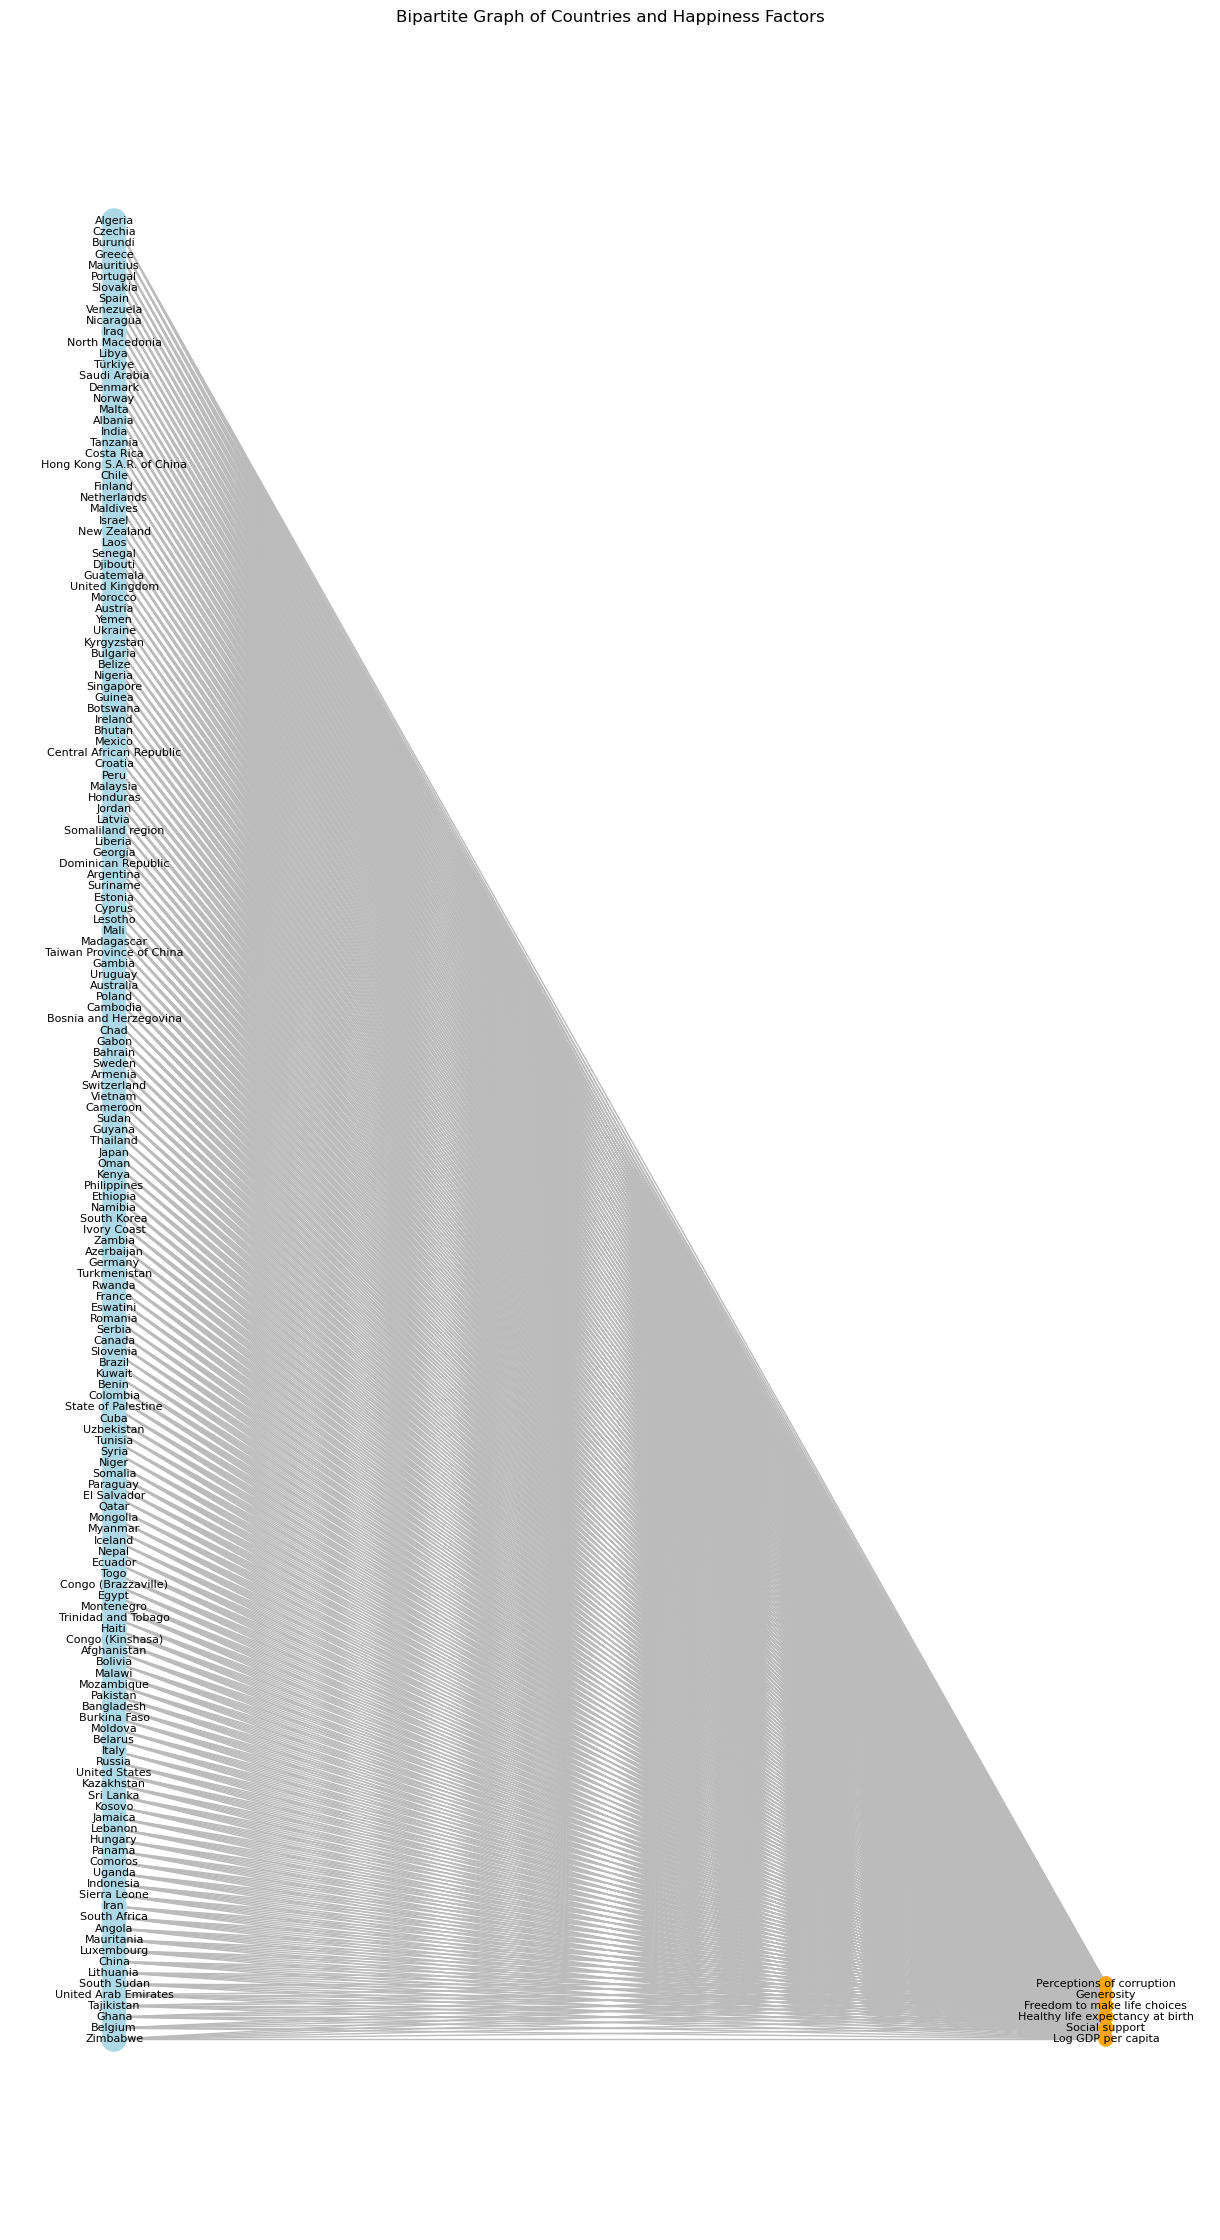

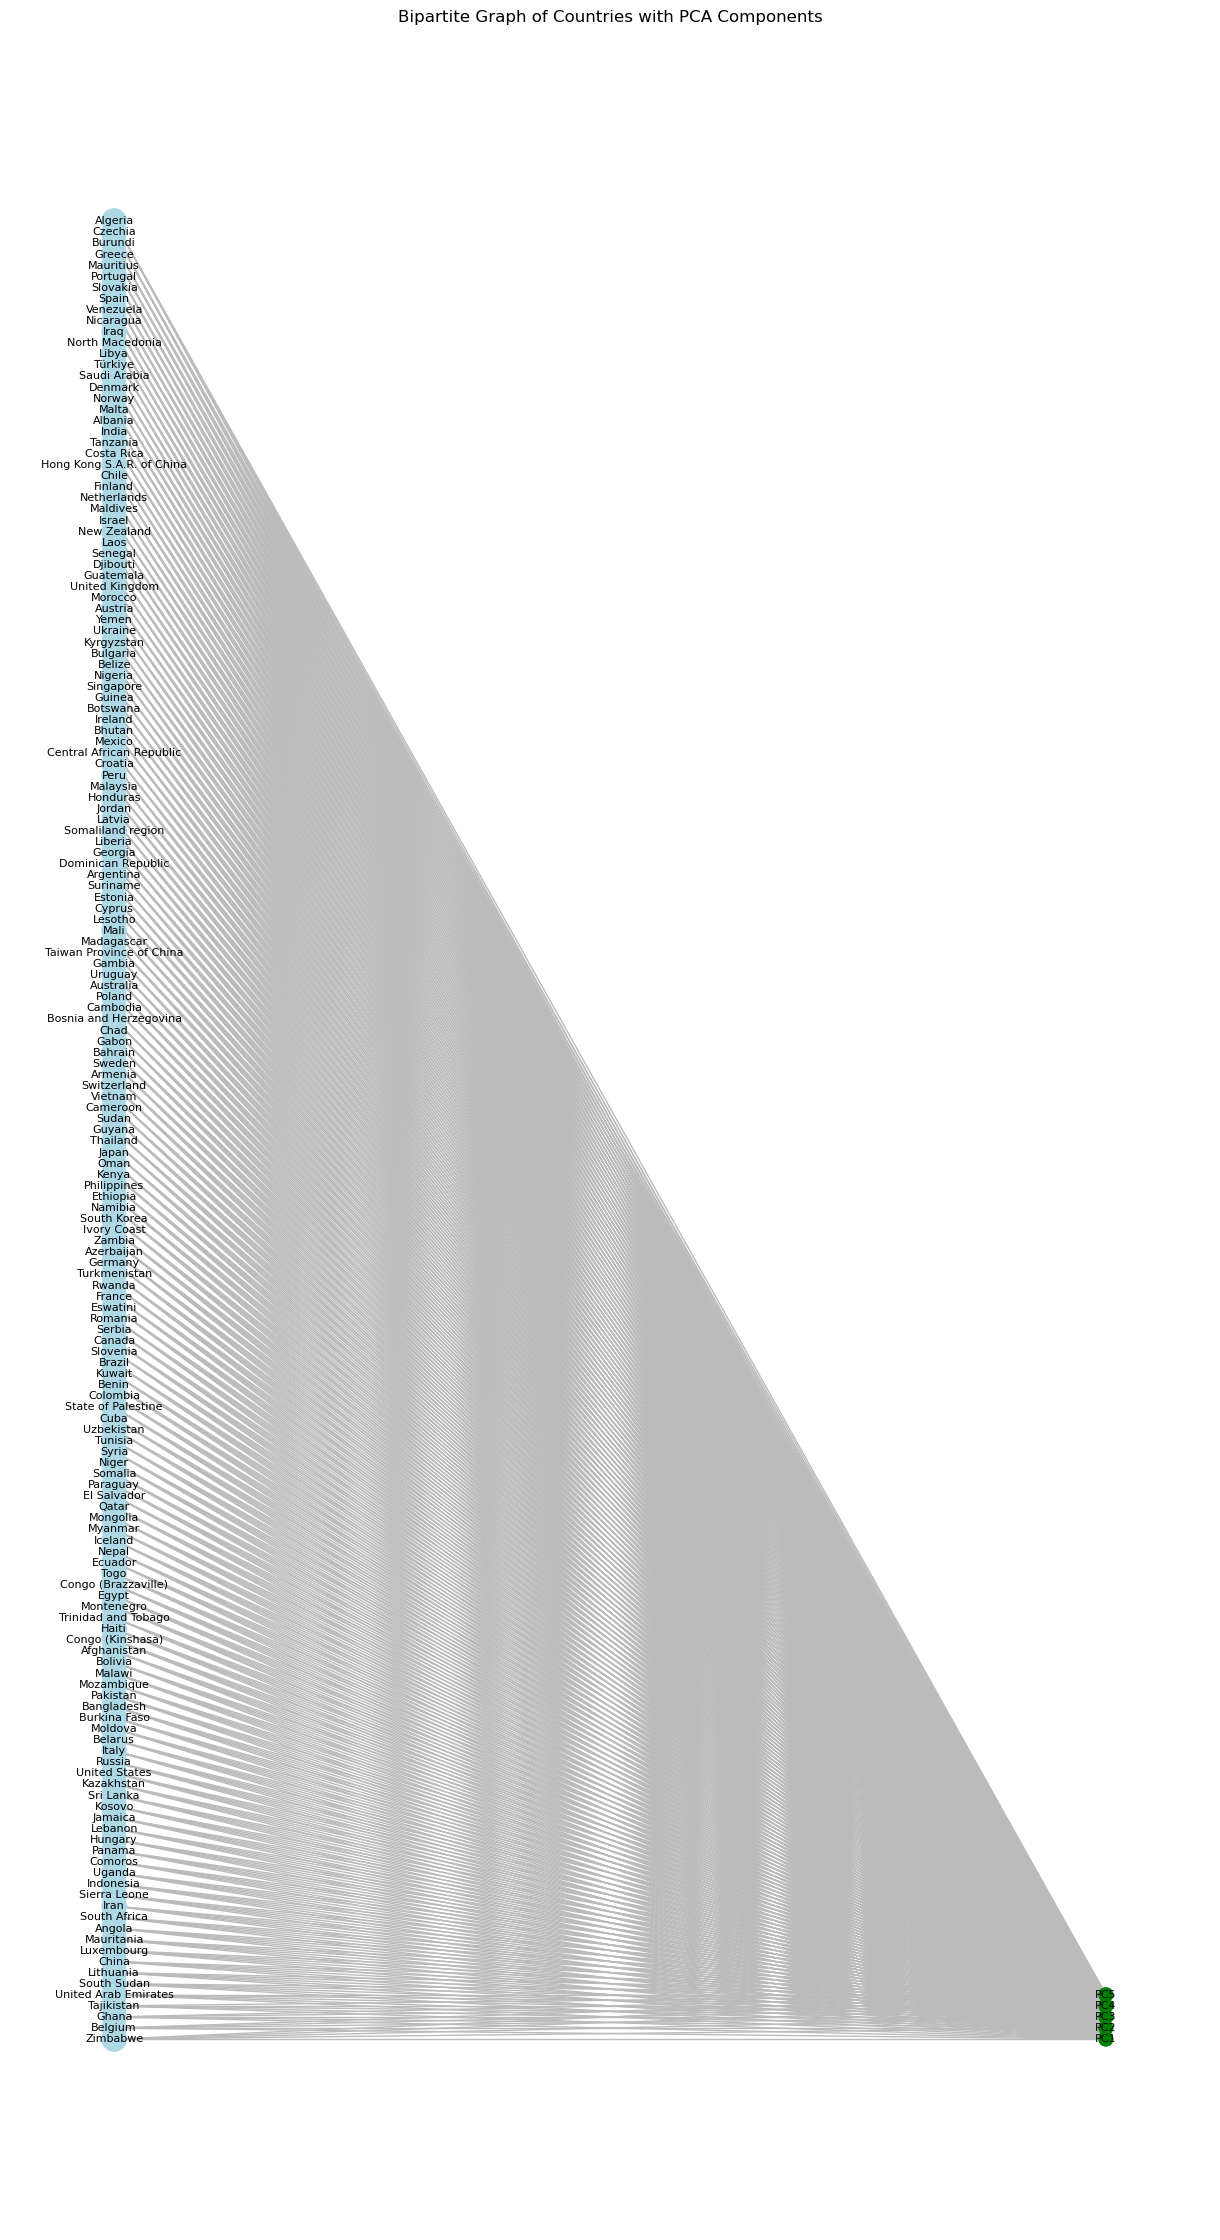

Log GDP per capita: 0.9706
Social support: 0.9706
Healthy life expectancy at birth: 0.9706
Freedom to make life choices: 0.9706
Generosity: 0.9706
Perceptions of corruption: 0.9706
Zimbabwe: 0.0353
Belgium: 0.0353
Ghana: 0.0353
Tajikistan: 0.0353
United Arab Emirates: 0.0353
South Sudan: 0.0353
Lithuania: 0.0353
China: 0.0353
Luxembourg: 0.0353
Mauritania: 0.0353
Angola: 0.0353
South Africa: 0.0353
Iran: 0.0353
Sierra Leone: 0.0353
Indonesia: 0.0353
Uganda: 0.0353
Comoros: 0.0353
Panama: 0.0353
Hungary: 0.0353
Lebanon: 0.0353
Jamaica: 0.0353
Kosovo: 0.0353
Sri Lanka: 0.0353
Kazakhstan: 0.0353
United States: 0.0353
Russia: 0.0353
Italy: 0.0353
Belarus: 0.0353
Moldova: 0.0353
Burkina Faso: 0.0353
Bangladesh: 0.0353
Pakistan: 0.0353
Mozambique: 0.0353
Malawi: 0.0353
Bolivia: 0.0353
Afghanistan: 0.0353
Congo (Kinshasa): 0.0353
Haiti: 0.0353
Trinidad and Tobago: 0.0353
Montenegro: 0.0353
Egypt: 0.0353
Congo (Brazzaville): 0.0353
Togo: 0.0353
Ecuador: 0.0353
Nepal: 0.0353
Iceland: 0.0353
Mya

In [14]:
# Function to draw bipartite graphs with improved aesthetics
def draw_bipartite_graph(B, title='Bipartite Graph', pos=None, node_color_map=None, figsize=(12, 22)):
    plt.figure(figsize=figsize)
    node_colors = [node_color_map.get(node, 'skyblue') for node in B]
    sizes = [300 if node in set(df['Country name']) else 100 for node in B]
    nx.draw(B, pos=pos, node_color=node_colors, node_size=sizes, with_labels=True, font_size=8, edge_color="#BBBBBB")
    plt.title(title)
    plt.show()

# Creating bipartite graph: Countries and Original Happiness Factors
B_original = nx.Graph()
countries = set(df['Country name'])
B_original.add_nodes_from(countries, bipartite=0)
B_original.add_nodes_from(features, bipartite=1)

for index, row in df.iterrows():
    for feature in features:
        if pd.notna(row[feature]):
            B_original.add_edge(row['Country name'], feature, weight=abs(row[feature]))

# Layout and color mapping for original factors
pos_original = dict()
pos_original.update((n, (1, i)) for i, n in enumerate(countries))  # put nodes from countries at x=1
pos_original.update((n, (2, i)) for i, n in enumerate(features))  # put nodes from features at x=2
color_map_original = {node: 'lightblue' if node in countries else 'orange' for node in B_original}

draw_bipartite_graph(B_original, 'Bipartite Graph of Countries and Happiness Factors', pos_original, color_map_original)

# Creating bipartite graph: Countries and PCA Components
B_pca = nx.Graph()
components = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
B_pca.add_nodes_from(countries, bipartite=0)
B_pca.add_nodes_from(components, bipartite=1)

for index, (country, row) in enumerate(zip(df['Country name'], principalDf.iterrows())):
    pc_values = row[1]
    for pc, value in pc_values.items():
        B_pca.add_edge(country, pc, weight=abs(value))

# Layout and color mapping for PCA components
pos_pca = dict()
pos_pca.update((n, (1, i)) for i, n in enumerate(countries))  # put nodes from countries at x=1
pos_pca.update((n, (2, i)) for i, n in enumerate(components))  # put nodes from components at x=2
color_map_pca = {node: 'lightblue' if node in countries else 'green' for node in B_pca}

draw_bipartite_graph(B_pca, 'Bipartite Graph of Countries with PCA Components', pos_pca, color_map_pca)



degree_centrality = nx.degree_centrality(B_original)
degree_centrality_pca = nx.degree_centrality(B_pca)
# Print degree centrality for each node
for node, centrality in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True):
    print(f"{node}: {centrality:.4f}")

# Identify the top 5 nodes (countries or factors) by degree centrality
top_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
print("Top 5 Nodes by Degree Centrality:")
for node, centrality in top_centrality:
    print(f"{node}: {centrality:.4f}")

    # Print degree centrality for each node
for node, centrality in sorted(degree_centrality_pca.items(), key=lambda item: item[1], reverse=True):
    print(f"{node}: {centrality:.4f}")

# Identify the top 5 nodes (countries or factors) by degree centrality
top_centrality = sorted(degree_centrality_pca.items(), key=lambda item: item[1], reverse=True)[:5]
print("Top 5 Nodes by Degree Centrality:")
for node, centrality in top_centrality:
    print(f"{node}: {centrality:.4f}")

